# Which car is the best choice considering cost performance?

# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Data preparation

In [2]:
data00 = pd.read_csv("../input/cheapest-electric-cars/Cheapestelectriccars-EVDatabase.csv")
data00

,Name,Subtitle,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,Drive,NumberofSeats,PriceinGermany,PriceinUK
0,Opel Ampera-e,Battery Electric Vehicle | 58 kWh,7.3 sec,150 km/h,335 km,173 Wh/km,210 km/h,Front Wheel Drive,5,"€42,990",NaN
1,Renault Kangoo Maxi ZE 33,Battery Electric Vehicle | 31 kWh,22.4 sec,130 km/h,160 km,194 Wh/km,-,Front Wheel Drive,5,NaN,"£31,680"
2,Nissan Leaf,Battery Electric Vehicle | 36 kWh,7.9 sec,144 km/h,220 km,164 Wh/km,230 km/h,Front Wheel Drive,5,"€29,990","£25,995"
3,Audi e-tron Sportback 55 quattro,Battery Electric Vehicle | 86.5 kWh,5.7 sec,200 km/h,375 km,231 Wh/km,600 km/h,All Wheel Drive,5,NaN,"£79,900"
4,Porsche Taycan Turbo S,Battery Electric Vehicle | 83.7 kWh,2.8 sec,260 km/h,390 km,215 Wh/km,860 km/h,All Wheel Drive,4,"€186,336","£138,830"
...,...,...,...,...,...,...,...,...,...,...,...
175,MG Marvel R,Battery Electric Vehicle | 65 kWh,7.9 sec,200 km/h,340 km,191 Wh/km,390 km/h,Rear Wheel Drive,5,"€40,000",NaN
176,Tesla Model 3 Long Range Dual Motor,Battery Electric Vehicle | 76 kWh,4.4 sec,233 km/h,490 km,155 Wh/km,820 km/h,All Wheel Drive,5,"€53,560",NaN
177,MG MG5 EV Long Range,Battery Electric Vehicle | 57 kWh,7.7 sec,185 km/h,340 km,168 Wh/km,340 km/h,Front Wheel Drive,5,NaN,"£26,495"
178,Audi Q4 e-tron 45 quattro,Battery Electric Vehicle | 76.6 kWh,6.9 sec,180 km/h,385 km,199 Wh/km,470 km/h,All Wheel Drive,5,"€50,900",NaN


In [3]:
print(data00.columns.tolist())

['Name', 'Subtitle', 'Acceleration', 'TopSpeed', 'Range', 'Efficiency', 'FastChargeSpeed', 'Drive', 'NumberofSeats', 'PriceinGermany', 'PriceinUK']


In [4]:
data0=data00.fillna('0')

In [5]:
PriceinUK=[]
for item in data0['PriceinUK']:
    PriceinUK+=[int(item.replace('£','').replace(',',''))]
data0['PriceinUK']=PriceinUK

In [6]:
PriceinGermany=[]
for item in data0['PriceinGermany']:
    PriceinGermany+=[int(item.replace('€','').replace(',',''))]
data0['PriceinGermany']=PriceinGermany

In [7]:
FastChargeSpeed=[]
for item in data0['FastChargeSpeed']:
    FastChargeSpeed+=[int(item.replace(' km/h','').replace('-','0'))]
data0['FastChargeSpeed']=FastChargeSpeed

In [8]:
Efficiency=[]
for item in data0['Efficiency']:
    Efficiency+=[int(item.replace(' Wh/km',''))]
data0['Efficiency']=Efficiency

In [9]:
Range=[]
for item in data0['Range']:
    Range+=[int(item.replace(' km',''))]
data0['Range']=Range

In [10]:
TopSpeed=[]
for item in data0['TopSpeed']:
    TopSpeed+=[int(item.replace(' km/h',''))]
data0['TopSpeed']=TopSpeed

In [11]:
Acceleration=[]
for item in data0['Acceleration']:
    Acceleration+=[float(item.replace(' sec',''))]
data0['Acceleration']=Acceleration

In [12]:
Subtitle=[]
for item in data0['Subtitle']:
    Subtitle+=[float(item.replace('Battery Electric Vehicle | ','').replace(' kWh','').replace('      ',''))]
data0['Subtitle']=Subtitle

In [13]:
df=data0
from sklearn.preprocessing import LabelEncoder
for c in df.columns:
    if df[c].dtype=='object': 
        df[c] = df[c].fillna('N')
        lbl = LabelEncoder()
        lbl.fit(list(df[c].values))
        df[c] = lbl.transform(df[c].values)

In [14]:
data1=df
data1

,Name,Subtitle,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,Drive,NumberofSeats,PriceinGermany,PriceinUK
0,97,58.0,7.3,150,335,173,210,1,5,42990,0
1,127,31.0,22.4,130,160,194,0,1,5,0,31680
2,94,36.0,7.9,144,220,164,230,1,5,29990,25995
3,15,86.5,5.7,200,375,231,600,0,5,0,79900
4,125,83.7,2.8,260,390,215,860,0,4,186336,138830
...,...,...,...,...,...,...,...,...,...,...,...
175,75,65.0,7.9,200,340,191,390,2,5,40000,0
176,147,76.0,4.4,233,490,155,820,0,5,53560,0
177,73,57.0,7.7,185,340,168,340,1,5,0,26495
178,6,76.6,6.9,180,385,199,470,0,5,50900,0


In [15]:
data1.columns

Index(['Name', 'Subtitle', 'Acceleration', 'TopSpeed', 'Range', 'Efficiency',
       'FastChargeSpeed', 'Drive', 'NumberofSeats', 'PriceinGermany',
       'PriceinUK'],
      dtype='object')

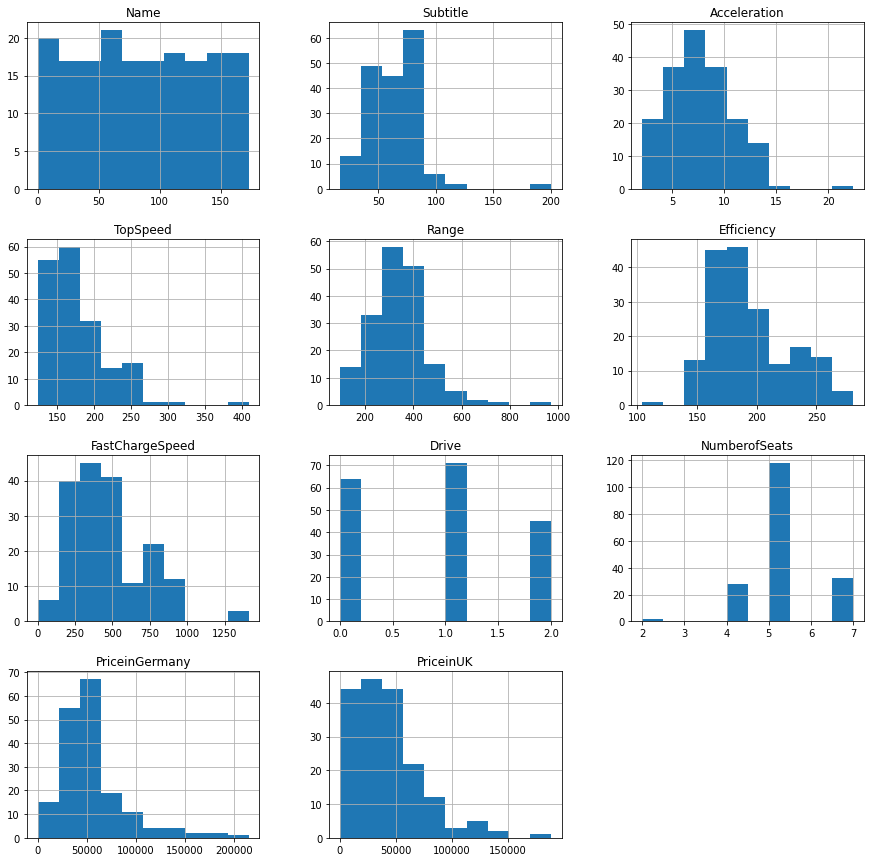

In [16]:
data1.iloc[:,:].hist(figsize=(15,15))
plt.show()

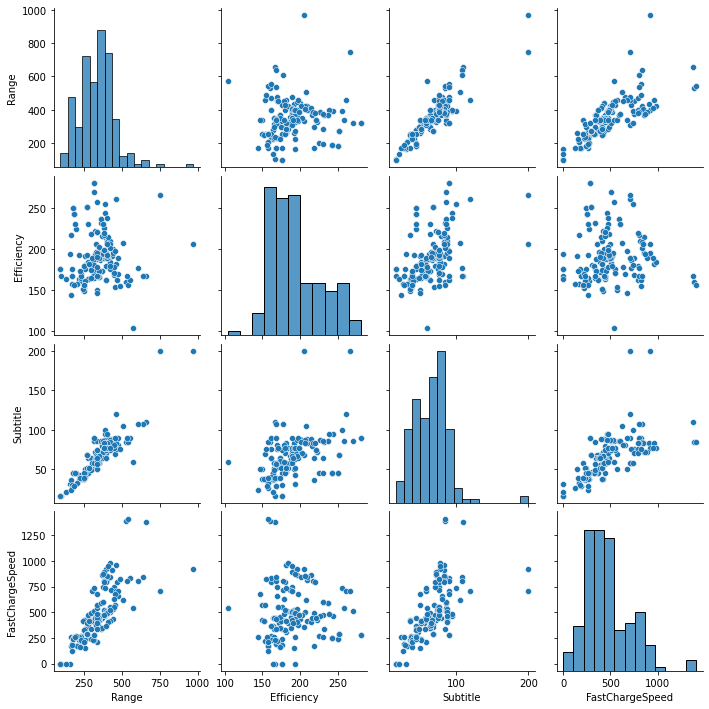

In [17]:
datap=data1[['Range','Efficiency','Subtitle','FastChargeSpeed']]
sns.pairplot(datap)
plt.show()

# Ranking on Battery Features

In [18]:
data2a=data00[['Name','Efficiency']]
data2a['Efficiency(Wh/km)']=data1['Efficiency']
data2a=data2a.groupby('Name',as_index=False).max()
data2a=data2a.sort_values('Efficiency(Wh/km)',ascending=False)
data2a

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Name,Efficiency,Efficiency(Wh/km)
87,Mercedes EQV 300 Long,281 Wh/km,281
86,Mercedes EQV 300 Extra-Long,281 Wh/km,281
12,Audi e-tron S 55 quattro,270 Wh/km,270
146,Tesla Cybertruck Tri Motor,267 Wh/km,267
144,Tesla Cybertruck Dual Motor,261 Wh/km,261
...,...,...,...
150,Tesla Model 3 Standard Range Plus LFP,150 Wh/km,150
41,Fiat 500e Hatchback 42 kWh,149 Wh/km,149
149,Tesla Model 3 Standard Range Plus,147 Wh/km,147
40,Fiat 500e Hatchback 24 kWh,144 Wh/km,144


In [19]:
fig = px.bar(data2a[0:40], x='Name', y='Efficiency(Wh/km)',title="Efficicney Ranknig of Electric Cars")
fig.show()

In [20]:
data2b=data00[['Name','Subtitle']]
data2b['Battery(kwh)']=data1['Subtitle']
data2b=data2b.groupby('Name',as_index=False).max()
data2b=data2b.sort_values('Battery(kwh)',ascending=False)
data2b

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,Subtitle,Battery(kwh)
157,Tesla Roadster,Battery Electric Vehicle | 200 kWh,200.0
146,Tesla Cybertruck Tri Motor,Battery Electric Vehicle | 200 kWh,200.0
144,Tesla Cybertruck Dual Motor,Battery Electric Vehicle | 120 kWh,120.0
69,Lucid Air Grand Touring,Battery Electric Vehicle | 110 kWh,110.0
84,Mercedes EQS 450+,Battery Electric Vehicle | 107.8 kWh,107.8
...,...,...,...
40,Fiat 500e Hatchback 24 kWh,Battery Electric Vehicle | 23.8 kWh,23.8
129,Renault Twingo Electric,Battery Electric Vehicle | 21.3 kWh,21.3
142,Smart EQ fortwo coupe,Battery Electric Vehicle | 16.7 kWh,16.7
141,Smart EQ fortwo cabrio,Battery Electric Vehicle | 16.7 kWh,16.7


In [21]:
fig = px.bar(data2b[0:40], x='Name', y='Battery(kwh)',title="Battery Ranknig of Electric Cars")
fig.show()

In [22]:
data2c=data00[['Name','Range']]
data2c['Range(km)']=data1['Range']
data2c=data2c.groupby('Name',as_index=False).max()
data2c=data2c.sort_values('Range(km)',ascending=False)
data2c

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,Range,Range(km)
157,Tesla Roadster,970 km,970
146,Tesla Cybertruck Tri Motor,750 km,750
69,Lucid Air Grand Touring,660 km,660
84,Mercedes EQS 450+,640 km,640
85,Mercedes EQS 580 4MATIC,610 km,610
...,...,...,...
127,Renault Kangoo Maxi ZE 33,160 km,160
129,Renault Twingo Electric,130 km,130
142,Smart EQ fortwo coupe,100 km,100
141,Smart EQ fortwo cabrio,95 km,95


In [23]:
fig = px.bar(data2c[0:40], x='Name', y='Range(km)',title="Range Ranknig of Electric Cars")
fig.show()

In [24]:
data2d=data00[['Name','FastChargeSpeed']]
data2d['FastChargeSpeed(km/h)']=data1['FastChargeSpeed']
data2d=data2d.groupby('Name',as_index=False).max()
data2d=data2d.sort_values('FastChargeSpeed(km/h)',ascending=False)
data2d

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,FastChargeSpeed,FastChargeSpeed(km/h)
70,Lucid Air Pure,1410 km/h,1410
71,Lucid Air Touring,1390 km/h,1390
69,Lucid Air Grand Touring,1380 km/h,1380
60,Kia EV6 Long Range 2WD,980 km/h,980
122,Porsche Taycan Plus,960 km/h,960
...,...,...,...
127,Renault Kangoo Maxi ZE 33,-,0
141,Smart EQ fortwo cabrio,-,0
140,Smart EQ forfour,-,0
129,Renault Twingo Electric,-,0


In [25]:
fig = px.bar(data2d[0:40], x='Name', y='FastChargeSpeed(km/h)',title="FastChargeSpeed Ranknig of Electric Cars")
fig.show()

# Target setting

In [26]:
target=['PriceinUK','PriceinGermany']

drop=[]
for i,item in enumerate(data1['PriceinUK']):
    if item ==0:
        drop+=[i]
print(drop)
data1=data1.drop(index=data1.index[drop]).reset_index(drop=True)

dataY=data1[target[0]]
dataX=data1.drop(target,axis=1)

[0, 13, 18, 27, 28, 29, 34, 45, 48, 63, 64, 78, 79, 89, 93, 98, 102, 104, 105, 106, 107, 108, 110, 111, 112, 115, 116, 117, 118, 119, 128, 140, 141, 143, 161, 162, 163, 164, 165, 166, 175, 176, 178, 179]


In [27]:
print(dataY[0:5].T)
print()
print(dataX[0:5].T)

0     31680
1     25995
2     79900
3    138830
4     30255
Name: PriceinUK, dtype: int64

                     0      1      2      3      4
Name             127.0   94.0   15.0  125.0   96.0
Subtitle          31.0   36.0   86.5   83.7   36.0
Acceleration      22.4    7.9    5.7    2.8   14.0
TopSpeed         130.0  144.0  200.0  260.0  123.0
Range            160.0  220.0  375.0  390.0  165.0
Efficiency       194.0  164.0  231.0  215.0  218.0
FastChargeSpeed    0.0  230.0  600.0  860.0  170.0
Drive              1.0    1.0    0.0    0.0    1.0
NumberofSeats      5.0    5.0    5.0    4.0    7.0


In [28]:
n=len(dataX)
print(n)
N=[]
for i in range(n):
    N+=[i]
random.seed(2021)
random.shuffle(N)

136


In [29]:
trainX=dataX.loc[N[0:(n//4)*3]]
trainY=dataY.loc[N[0:(n//4)*3]]
testX=dataX.loc[N[(n//4)*3:]]
testY=dataY.loc[N[(n//4)*3:]]

In [30]:
df_columns = list(dataX.columns)
print(df_columns)

['Name', 'Subtitle', 'Acceleration', 'TopSpeed', 'Range', 'Efficiency', 'FastChargeSpeed', 'Drive', 'NumberofSeats']


In [31]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [32]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [33]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [34]:
train_feat_df = to_feature(trainX)
test_feat_df = to_feature(testX)

100%|██████████| 1/1 [00:00<00:00, 477.17it/s]

createcreate_numeric_feature  0.002[s]
createcreate_numeric_feature  0.001[s]


# Model

In [35]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [36]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [37]:
y = trainY
print(y.shape)
print(type(y))

(102,)
<class 'pandas.core.series.Series'>


In [38]:
ydf=pd.DataFrame(y)
ydf

,PriceinUK
38,83580
34,19795
71,52500
65,30895
15,30550
...,...
85,30345
43,49980
67,42250
35,30160


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[182]	valid_0's rmse: 9144.84
fit fold=0  0.113[s]
Fold 0 RMSLE: 9144.8385

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 7419.18
fit fold=1  0.033[s]
Fold 1 RMSLE: 7419.1824

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 11288.6
fit fold=2  0.023[s]
Fold 2 RMSLE: 11288.6116

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 11463.1
fit fold=3  0.026[s]
Fold 3 RMSLE: 11463.1361

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 10601.8
Early stopping, best iteration is:
[558]	valid_0's rmse: 10513.1
fit fold=4  0.131[s]
Fold 4 RMSLE: 10513.1221

--------------------------------------------------
FINISHED | Whole RMSLE: 10048.5872


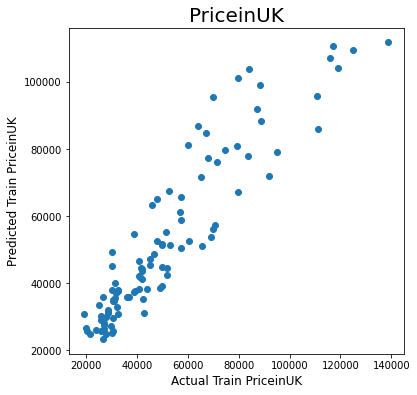

In [39]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_ylabel('Predicted Train '+target[i],fontsize=12)
    ax.set_xlabel('Actual Train '+target[i],fontsize=12)
    ax.scatter(y,oof)

# Cost Performance is defined as ...
### (Predicted price - Actual price) / (Actual price)

In [40]:
ydf['oof']=oof
ydf['rate']=(ydf['oof']-ydf['PriceinUK'])/ydf['PriceinUK']
ydf.sort_values('rate',ascending=False)

,PriceinUK,oof,rate
133,30375,49395.576361,0.626192
32,19200,30754.768305,0.601811
4,30255,45234.823352,0.495119
48,39000,54619.649225,0.400504
120,45900,63339.151174,0.379938
...,...,...,...
108,91905,72018.074940,-0.216386
47,69100,53934.775938,-0.219468
83,65720,51100.834360,-0.222446
96,110980,85992.580028,-0.225152


## the Lowest on cost performance

In [41]:
data1.loc[119:119]

,Name,Subtitle,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,Drive,NumberofSeats,PriceinGermany,PriceinUK
119,115,75.0,7.4,160,425,176,550,1,5,49500,42900


In [42]:
data00[data00['PriceinUK']=='£42,900']

,Name,Subtitle,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,Drive,NumberofSeats,PriceinGermany,PriceinUK
153,Polestar 2 Long Range Single Motor,Battery Electric Vehicle | 75 kWh,7.4 sec,160 km/h,425 km,176 Wh/km,550 km/h,Front Wheel Drive,5,"€49,500","£42,900"


# **Polestar 2 Long Range Single Motor**

![https://i1.wp.com/electrek.co/wp-content/uploads/sites/3/2020/08/Polestar2_US_Launch-0007-2000.jpg?w=2500&quality=82&strip=all&ssl=1](https://i1.wp.com/electrek.co/wp-content/uploads/sites/3/2020/08/Polestar2_US_Launch-0007-2000.jpg?w=2500&quality=82&strip=all&ssl=1)

## the Highest on cost performance

In [43]:
data1.loc[133:133]

,Name,Subtitle,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,Drive,NumberofSeats,PriceinGermany,PriceinUK
133,108,45.0,11.7,135,200,225,270,1,7,37590,30375


In [44]:
data00[data00['PriceinUK']=='£30,375']

,Name,Subtitle,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,Drive,NumberofSeats,PriceinGermany,PriceinUK
173,Peugeot e-Rifter Standard 50 kWh,Battery Electric Vehicle | 45 kWh,11.7 sec,135 km/h,200 km,225 Wh/km,270 km/h,Front Wheel Drive,7,"€37,590","£30,375"


# **Peugeot e-Rifter Standard 50 kWh**

![https://ev-database.org/img/auto/Peugeot_e-Rifter/Peugeot_e-Rifter-02.jpg](https://ev-database.org/img/auto/Peugeot_e-Rifter/Peugeot_e-Rifter-02.jpg)

# Visualize Importance

In [45]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[182]	valid_0's rmse: 9144.84
fit fold=0  0.059[s]
Fold 0 RMSLE: 9144.8385

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 7419.18
fit fold=1  0.031[s]
Fold 1 RMSLE: 7419.1824

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 11288.6
fit fold=2  0.021[s]
Fold 2 RMSLE: 11288.6116

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 11463.1
fit fold=3  0.023[s]
Fold 3 RMSLE: 11463.1361

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 10601.8
Early stopping, best iteration is:
[558]	valid_0's rmse: 10513.1
fit fold=4  0.127[s]
Fold 4 RMSLE: 10513.1221

--------------------------------------------------
FINISHED | Whole RMSLE: 10048.5872


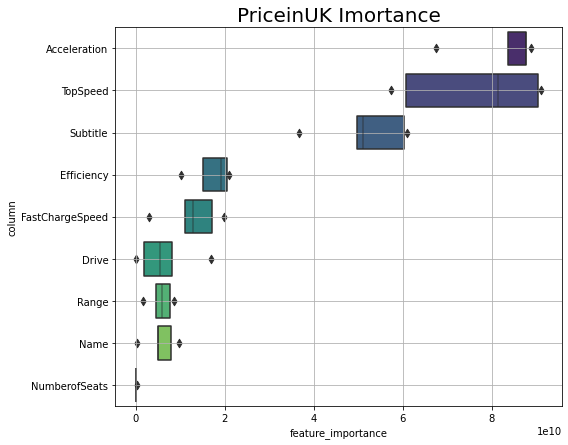

In [46]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)


In [47]:
pred0 = np.array([model.predict(test_feat_df.values) for model in models])
PRED = pred0[4]
PRED[0:5]

array([40970.73679126, 54799.16280472, 94378.66315614, 40702.81877357,
       25137.40870638])

In [48]:
ANS=np.array(testY)
ANS[0:5]

array([40800, 59990, 90000, 25995, 26795])

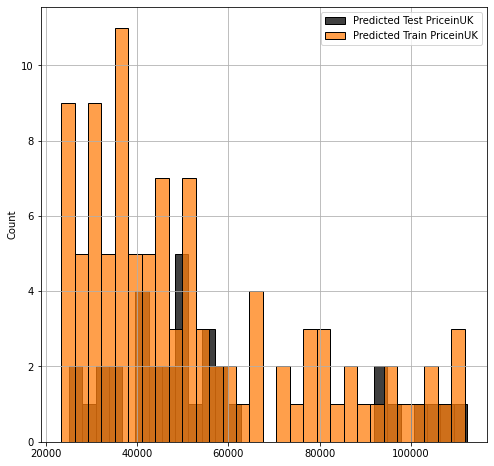

In [49]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(PRED, label='Predicted Test '+target[0], ax=ax, color='black',bins=30)
sns.histplot(oof, label='Predicted Train '+target[0], ax=ax, color='C1',bins=30)
ax.legend()
ax.grid()

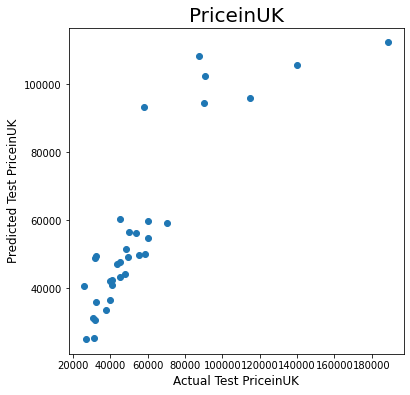

In [50]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title(target[0],fontsize=20)
ax.set_xlabel('Actual Test '+target[0],fontsize=12)
ax.set_ylabel('Predicted Test '+target[0],fontsize=12)
ax.scatter(ANS,PRED)